In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import kagglehub

In [2]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

In [3]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)

images_dir = os.path.join(path, 'flickr30k_images')
captions_file = os.path.join(path, 'captions.txt')

print(f"{Colour.GREEN}Environment configured successfully.{Colour.END}")

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1
Environment configured successfully.


In [4]:
print(f"{Colour.BLUE}Loading captions file...{Colour.END}")

df = pd.read_csv(captions_file)
df.columns = [col.strip() for col in df.columns]
df.rename(columns={'image_name': 'image', 'comment_number': 'id', 'comment': 'caption'}, inplace=True)
missing_count = df['caption'].isnull().sum()

if missing_count > 0:
    print(f"{Colour.YELLOW}Found {missing_count} missing values. Removing them...{Colour.END}")
    df.dropna(inplace=True)
    
print(f"{Colour.GREEN}Dataset loaded.{Colour.END} Shape: {df.shape}")

Loading captions file...
Dataset loaded. Shape: (158915, 3)


In [5]:
# Computing basic statistics
total_images = df['image'].nunique()
total_captions = len(df)
vocab_set = set(" ".join(df['caption'].astype(str)).lower().split())
vocab_size = len(vocab_set)

print(f"{Colour.BOLD}=== DATASET OVERVIEW ==={Colour.END}")
print(f"Total Images      : {Colour.CYAN}{total_images:,}{Colour.END}")
print(f"Total Captions    : {Colour.CYAN}{total_captions:,}{Colour.END}")
print(f"Captions per Image: {Colour.CYAN}{total_captions/total_images:.1f}{Colour.END}")
print(f"Vocabulary Size   : {Colour.CYAN}{vocab_size:,}{Colour.END} unique words")

=== DATASET OVERVIEW ===
Total Images      : 31,783
Total Captions    : 158,915
Captions per Image: 5.0
Vocabulary Size   : 20,320 unique words


In [6]:
def plot_caption_distribution(df):
    df['word_count'] = df['caption'].astype(str).apply(lambda x: len(x.split()))
    data = df['word_count']
    mean_val = data.mean()

    fig, ax = plt.subplots(figsize=(12, 6), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    n, bins, patches = plt.hist(data, bins=50, color='#61afef', alpha=0.8, edgecolor=vscode_bg, linewidth=0.5)

    plt.axvline(mean_val, color='#e06c75', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_val:.1f} words')
    plt.xlabel('Caption Length (words)', fontsize=14, color=text_color)
    plt.ylabel('Frequency', fontsize=14, color=text_color)
    plt.title('Distribution of Caption Lengths', fontsize=16, color=text_color, pad=20)

    ax.tick_params(axis='both', colors=text_color, labelsize=11, length=6, width=1.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(text_color)
    ax.spines['bottom'].set_linewidth(1.2)

    plt.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.2, color='white', axis='y')

    legend = plt.legend(loc='upper right', fontsize=12, frameon=False)
    for text in legend.get_texts():
        text.set_color(text_color)

    ax.set_xlim(0, 40)
    plt.tight_layout()
    plt.show()

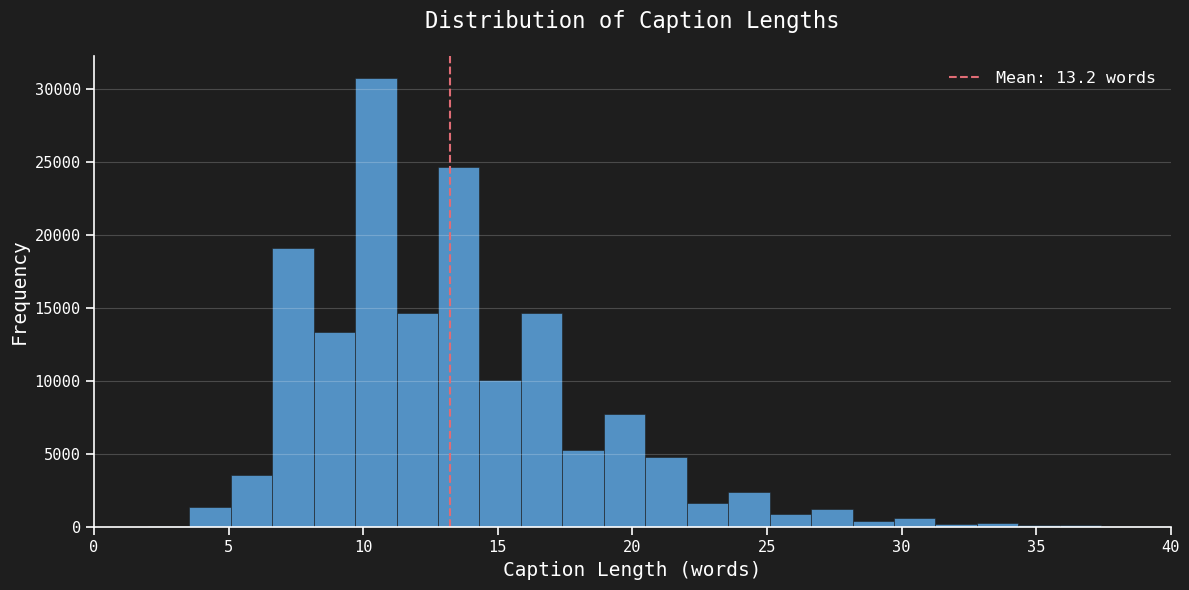

In [7]:
plot_caption_distribution(df)

In [8]:
def visualize_sample(df, img_folder):
    sample_row = df.sample(1)
    img_name = sample_row['image'].values[0]
    captions = df[df['image'] == img_name]['caption'].values
    img_path = os.path.join(img_folder, img_name)
    
    try:
        image = Image.open(img_path)
        
        fig, ax = plt.subplots(figsize=(8, 8), facecolor=vscode_bg)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Sample Image ID: {img_name}", fontsize=14, color=text_color, pad=10)
        plt.show()
        
        print(f"{Colour.BOLD}Captions:{Colour.END}")
        for i, cap in enumerate(captions, 1):
            print(f"{Colour.CYAN}[{i}]{Colour.END} {cap}")
            
    except Exception as e:
        print(f"{Colour.RED}[ERROR] Could not load image: {e}{Colour.END}")

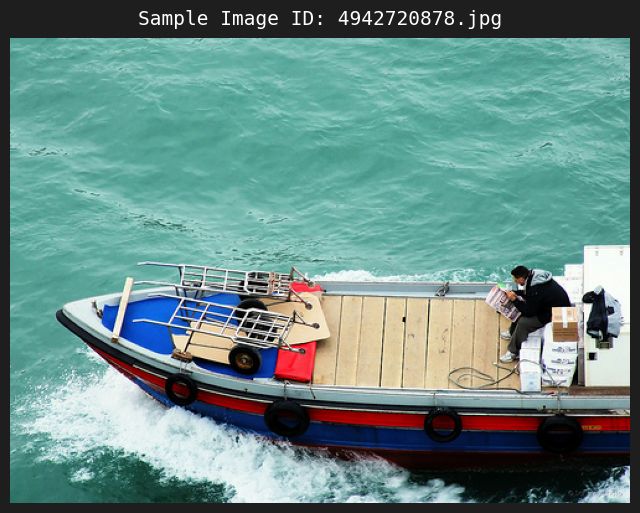

Captions:
[1] A boat rushes along the water as a man sits on the deck and reads a newspaper .
[2] A man sits and reads a newspaper on a boat going through the water .
[3] A man is sitting aboard a vessel and reading a newspaper .
[4] A man sitting on a boat in the middle of the ocean .
[5] A man reading a newspaper on a moving boat .


In [9]:
visualize_sample(df, images_dir)

In [10]:
def visualize_same_size_grid(df, img_folder):
    size_buckets = defaultdict(list)
    selected_imgs = []
    found_dims = None
    unique_images = df['image'].unique()
    np.random.shuffle(unique_images)

    for img_name in unique_images:
        img_path = os.path.join(img_folder, img_name)
        try:
            with Image.open(img_path) as img:
                dims = img.size # Returns (width, height)
                size_buckets[dims].append(img_name)
                if len(size_buckets[dims]) == 4:
                    selected_imgs = size_buckets[dims]
                    found_dims = dims
                    break # Stop searching immediately
        except Exception:
            continue

    if not selected_imgs:
        print(f"{Colour.RED}could not find 4 images with matching sizes (unexpected).{Colour.END}")
        return


    fig, axes = plt.subplots(2, 2, figsize=(14, 12), facecolor=vscode_bg)

    for idx, img_name in enumerate(selected_imgs):
        row = idx // 2
        col = idx % 2
        ax = axes[row, col]
        
        ax.set_facecolor(vscode_bg)
        ax.axis('off')
        
        img_path = os.path.join(img_folder, img_name)
        image = Image.open(img_path)
        ax.imshow(image)
        
        first_caption = df[df['image'] == img_name]['caption'].values[0]
        truncated_cap = (first_caption[:64] + '...') if len(first_caption) > 64 else first_caption
        ax.set_title(f"{truncated_cap}", fontsize=11, color=text_color, pad=10)

    plt.tight_layout()
    plt.show()

    print(f"{Colour.GREEN}{Colour.BOLD}Detailed Captions:{Colour.END}")
    for img_name in selected_imgs:
        captions = df[df['image'] == img_name]['caption'].values
        print(f"\n{Colour.CYAN}Image ID: {img_name} {Colour.END}({found_dims[0]}x{found_dims[1]})")
        for i, cap in enumerate(captions, 1):
            print(f"  [{i}] {cap}")

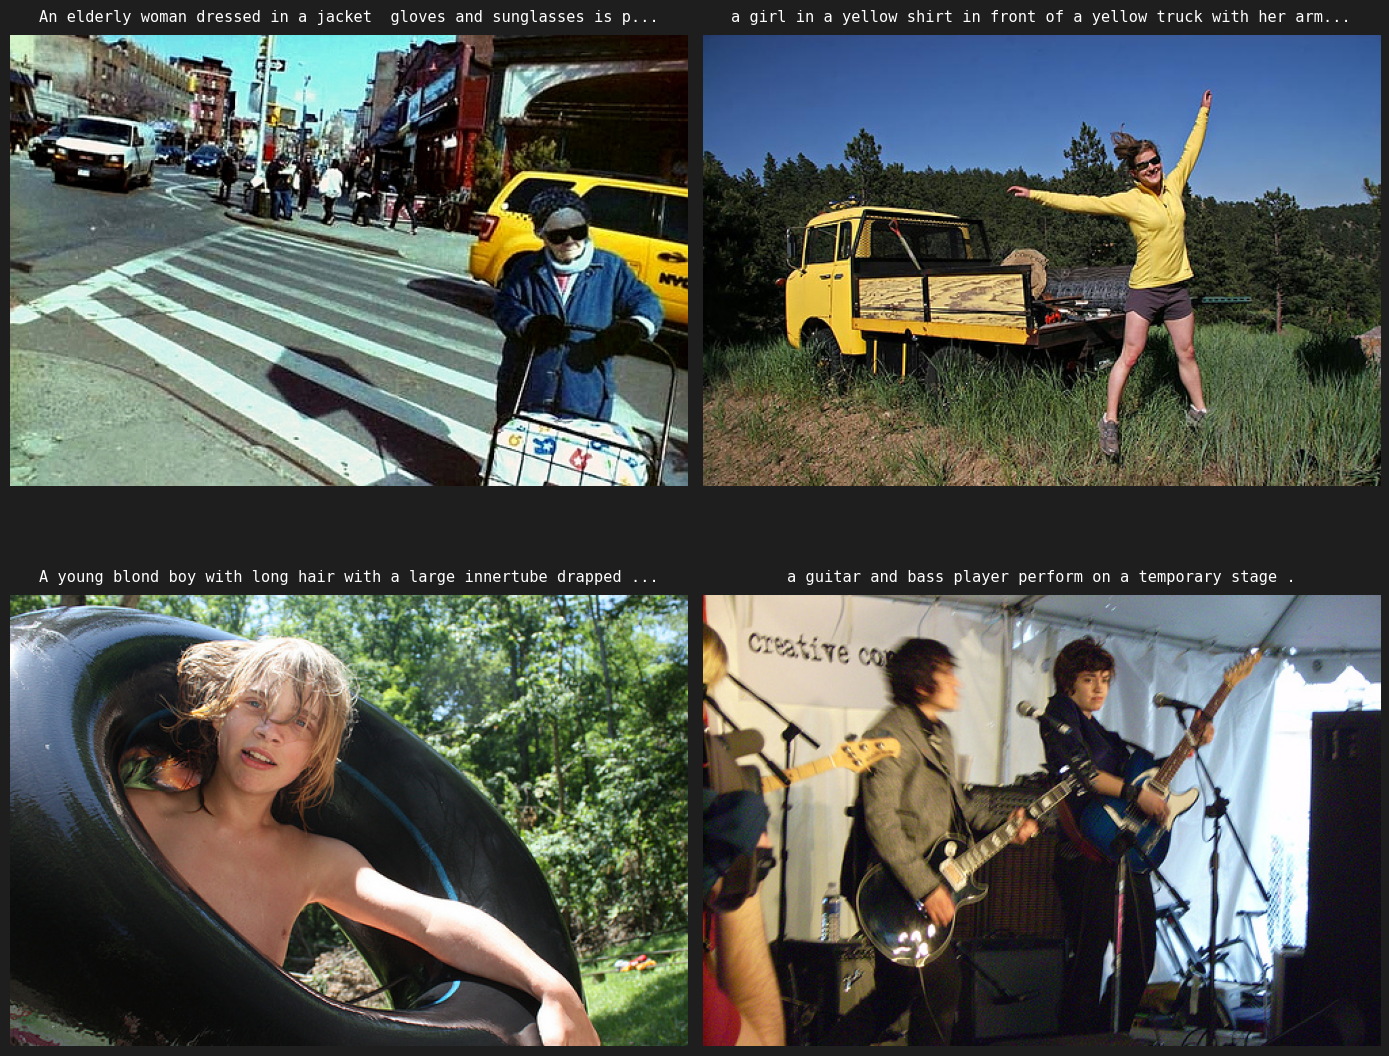

Detailed Captions:

Image ID: 4446482718.jpg (500x333)
  [1] An elderly woman dressed in a jacket  gloves and sunglasses is pushing a basket on a busy city street .
  [2] A woman in gloves and a scarf crosses a busy street with a cart and Toys R Us bag .
  [3] An elderly woman crossing the street with her shopping cart .
  [4] An elderly woman with a cart crosses a city street .
  [5] An elderly woman crossing a busy city street .

Image ID: 573946592.jpg (500x333)
  [1] a girl in a yellow shirt in front of a yellow truck with her arms in the air and a forest in the backdrop .
  [2] A woman with her arms spread standing in front of a yellow pick-up truck .
  [3] A girl in a bright yellow jacket poses in front of a bright yellow truck .
  [4] One person wearing a yellow shirt  in a field  next to a truck .
  [5] A woman is posing in a meadow next to an old truck .

Image ID: 2801851082.jpg (500x333)
  [1] A young blond boy with long hair with a large innertube drapped around his body
  

In [11]:
visualize_same_size_grid(df, images_dir)

In [ ]:
def plot_wordcloud(df):
    text = " ".join(caption for caption in df.caption.astype(str))
    
    wordcloud = WordCloud(width=1000, height=500, background_color=vscode_bg, colormap='Pastel1', stopwords=STOPWORDS).generate(text)

    fig, ax = plt.subplots(figsize=(14, 7), facecolor=vscode_bg)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    plt.show()

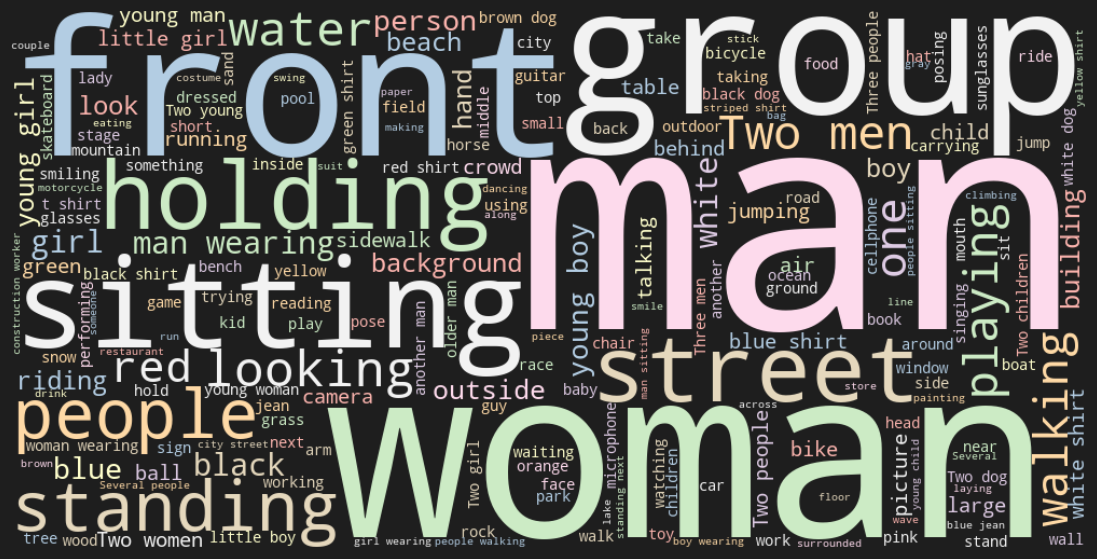

In [13]:
plot_wordcloud(df)